In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymysql

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

import tensorflow as tf
from tensorflow import keras #케라스
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Concatenate, Input
from sklearn.preprocessing import MinMaxScaler

tf.keras.utils.set_random_seed(42) #seed
tf.config.experimental.enable_op_determinism() #텐서플로 연산 고정

In [2]:
### Table : train
conn = pymysql.connect(host='localhost'
                       ,user = 'root'
                       ,password = 'dbdb1021&'
                       ,db='ion'
                       ,charset='utf8'
                       ,cursorclass=pymysql.cursors.DictCursor)
cursor = conn.cursor()

for val in ['train', 'ttf', 'fault']:
    # 4단계 : sql문 작성(데이터 read)
    sql = "SELECT * FROM ion.m02_01_{};".format(val)

    # 5단계 : sql문 실행(데이터 read)
    cursor.execute(sql)

    # 6단계 : fetch 메서드(조회결과 콘솔창에서 보기 위함)
    result = cursor.fetchall() # fetchall() : 전부 가져오기

    # 9단계 : df
    globals()['df_{}'.format(val)] = pd.DataFrame(result)

# 8단계 : commit 및 연결 해제
conn.commit() # 커밋은 반복할 필요 없음
conn.close()

In [88]:
std = df_train['IONGAUGEPRESSURE'].std()
df_train_c = df_train[(df_train['IONGAUGEPRESSURE']<=std*3) & (df_train['IONGAUGEPRESSURE']>=std*(-3))]
print(df_train_c.shape)

std = df_train['ETCHSUPPRESSORCURRENT'].std()
df_train_c = df_train_c[(df_train_c['ETCHSUPPRESSORCURRENT']<=std*3) & (df_train_c['ETCHSUPPRESSORCURRENT']>=std*(-3))]
print(df_train_c.shape)

std = df_train['FLOWCOOLPRESSURE'].std()
df_train_c = df_train_c[(df_train_c['FLOWCOOLPRESSURE']<=std*3) & (df_train_c['FLOWCOOLPRESSURE']>=std*(-3))]
print(df_train_c.shape)

df_train_c[:5]

(5109975, 24)
(5109939, 24)
(5092355, 24)


,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-1.751661,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-1.747158,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-1.747158,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785


In [89]:
df_ttf_dup = df_ttf[df_ttf.duplicated(subset='time')==False]
df_ttf_dup.to_csv('01_M02_DC_train_ttf_dup.csv')

In [2]:
df_train_c = pd.read_csv('01_M02_DC_train_pre.csv').iloc[:, 1:]
df_ttf_dup = pd.read_csv('01_M02_DC_train_ttf_dup.csv')
df = pd.merge(df_train_c, df_ttf_dup.iloc[:,:2], how='left', on='time')
df = df.dropna()
df[:5]

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,TTF_FlowCool Pressure Dropped Below Limit
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623234.0
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623230.0
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623226.0
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623222.0
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623218.0


In [36]:
# 시간으로 index 찾기
temp = df_train.set_index("time")
print(df_train[(df_train['time'] == 3915072)].index)
temp.loc[3915072,:]

Index([132695], dtype='int64')


Tool                          01M02
stage                             1
Lot                            9361
runnum                     10548007
recipe                           67
recipe_step                      43
IONGAUGEPRESSURE          -0.024606
ETCHBEAMVOLTAGE            1.188529
ETCHBEAMCURRENT            0.785806
ETCHSUPPRESSORVOLTAGE      1.070426
ETCHSUPPRESSORCURRENT      0.541194
FLOWCOOLFLOWRATE           0.569103
FLOWCOOLPRESSURE           0.249374
ETCHGASCHANNEL1READBACK   -0.055042
ETCHPBNGASREADBACK         0.354293
FIXTURETILTANGLE           0.022131
ROTATIONSPEED             -0.013207
ACTUALROTATIONANGLE       -0.122455
FIXTURESHUTTERPOSITION          1.0
ETCHSOURCEUSAGE            2.791555
ETCHAUXSOURCETIMER         3.314825
ETCHAUX2SOURCETIMER        3.636821
ACTUALSTEPDURATION         0.803526
Name: 3915072, dtype: object

# 시간이 불규칙한 이유 찾기

In [48]:
# 중복치 제거
df_train_dup = df_train[df_train.duplicated(subset=['time'], keep='first') == False]
df_train_dup = df_train_dup.reset_index(drop=True)

In [73]:
idx = df_train[df_train['time']==3289926].index[0]
print(idx)
df_train.iloc[idx-5:idx+5,:]

1473


,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
1468,3289706,01M02,1,9253,10511673,67,49,-0.078725,-0.959269,-0.959297,...,-1.743905,-2.784389,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1469,3289710,01M02,1,9253,10511673,67,49,-0.078774,-0.959213,-0.959013,...,-1.743905,-2.782111,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1470,3289714,01M02,1,9253,10511673,67,49,-0.078730,-0.958985,-0.959793,...,-1.745656,-2.782111,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1471,3289718,01M02,1,9253,10511673,67,49,-0.078783,-0.959156,-0.959509,...,-1.745656,-2.782111,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1472,3289722,01M02,1,9253,10511673,67,49,-0.078829,-0.959269,-0.959084,...,-1.745656,-2.783162,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1473,3289926,01M02,88,9254,10511673,68,1,-0.079441,-0.958985,-0.958871,...,-1.750410,-2.780884,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1474,3289930,01M02,88,9254,10511673,68,1,-0.079441,-0.958701,-0.958871,...,-1.747158,-2.782111,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1475,3289934,01M02,88,9254,10511673,68,1,-0.079441,-0.958928,-0.958871,...,-1.747158,-2.782111,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1476,3289938,01M02,88,9254,10511673,68,1,-0.079441,-0.958587,-0.959084,...,-1.743905,-2.782111,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941
1477,3289942,01M02,88,9254,10511673,68,1,-0.079451,-0.959042,-0.959155,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122455,0.0,2.400042,2.876737,3.181374,-0.604941


In [68]:
dic = {}

for i in range(1, len(df_train_dup)):
    if (df_train_dup['time'][i] - df_train_dup['time'][i-1]) == 4:
        pass
    else:
        dic.update({i:df_train_dup['time'][i]})

In [96]:
idx = 5810
df_train.iloc[idx-5:idx+5,:]

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
5805,3308898,01M02,1,9258,10512449,66,3,0.003304,-0.951136,-0.958729,...,-0.058299,0.350789,-0.200727,-0.013207,-0.122473,1.0,2.413247,2.891516,3.196739,-0.66754
5806,3308902,01M02,1,9258,10512449,66,3,0.003304,-0.950909,-0.959155,...,-0.058299,0.350789,-0.200727,-0.013207,-0.122473,1.0,2.413250,2.891520,3.196742,-0.66754
5807,3308906,01M02,1,9258,10512449,66,3,0.003304,-0.951478,-0.959155,...,-0.061544,0.357450,-0.200727,-0.013207,-0.122473,1.0,2.413253,2.891523,3.196746,-0.66754
5808,3308910,01M02,1,9258,10512449,66,3,0.003304,-0.951136,-0.959155,...,-0.061544,0.357450,-0.200727,-0.013207,-0.122473,1.0,2.413257,2.891529,3.196752,-0.66754
5809,3308914,01M02,1,9258,10512449,66,3,0.003304,-0.951136,-0.958445,...,-0.048540,0.357450,-0.200727,-0.013207,-0.122473,1.0,2.413260,2.891533,3.196756,-0.66754
5810,3308920,01M02,1,9258,10512449,66,3,0.003304,-0.951250,-0.958800,...,-0.048540,0.350789,-0.200727,-0.013207,-0.122473,1.0,2.413265,2.891536,3.196760,-0.66754
5811,3308922,01M02,1,9258,10512449,66,3,0.003304,-0.950966,-0.959226,...,-0.048540,0.350789,-0.200727,-0.013207,-0.122473,1.0,2.413266,2.891538,3.196762,-0.66754
5812,3308926,01M02,1,9258,10512449,66,3,0.003304,-0.950966,-0.959438,...,-0.053538,0.360776,-0.200727,-0.013207,-0.122473,1.0,2.413270,2.891542,3.196766,-0.66754
5813,3308930,01M02,1,9258,10512449,66,3,0.003304,-0.951250,-0.959013,...,-0.053538,0.360776,-0.200727,-0.013207,-0.122473,1.0,2.413273,2.891546,3.196769,-0.66754
5814,3308934,01M02,1,9258,10512449,66,3,0.003304,-0.950909,-0.959155,...,-0.053538,0.360776,-0.200727,-0.013207,-0.122473,1.0,2.413276,2.891551,3.196775,-0.66754


In [120]:
### 특정 lot (공정이 오래 걸리는)이 있는가?

dic_lis = list(dic.keys())
id=[]
lot=[]

for i in range(1,len(dic_lis)):
    if df_train_dup['Lot'][dic_lis[i]] == df_train_dup['Lot'][dic_lis[i-1]]:
        id.append(dic_lis[i])
        lot.append(df_train_dup['Lot'][dic_lis[i]])
        
a = pd.DataFrame([id,lot]).transpose()
a.columns = ['id', 'lot']
a = a[a.duplicated(subset=['lot'], keep='first')==False]
a = a.reset_index(drop=True)
a

,id,lot
0,5810,9258
1,6860,9186
2,7543,9259
3,7907,9260
4,9944,9255
...,...,...
887,5061692,4688
888,5067749,4190
889,5072539,9977
890,5092789,4329


# 시간이 일정하지 않은 경우의 수 확인

In [127]:
cnt = 0
dic_hap = {}

for idx in a['id']:
    hap = (df_train_dup.iloc[idx,0] - df_train_dup.iloc[idx-1,0]) + (df_train_dup.iloc[idx+1,0] - df_train_dup.iloc[idx,0])
    if hap % 4 !=0:
        cnt += 1
        c = (df_train_dup.iloc[idx,0] - df_train_dup.iloc[idx-1,0])
        b = (df_train_dup.iloc[idx+1,0] - df_train_dup.iloc[idx,0])
        dic_hap.update({idx:[c,b]})
        # print(idx)
        # display(df_train_dup.iloc[idx-5:idx+5,:])
cnt

151

In [189]:
b = pd.DataFrame(dic_hap.values())
b[b.duplicated()==False]

,0,1
0,2,8
2,6,4
4,2,4
11,8,2
13,68,2
14,64,2
16,72,2
17,16,2
33,6,8
45,76,2


In [171]:
s1=set()
for i in list(dic_hap.values()):
    s1.update(i)

In [153]:
# 시간 패턴 입력하면 어느 인덱스인지 찾는 함수
def elements_in_list(in_list):
    lis_val = list(dic_hap.values())
    lis_temp2 = list(filter(lambda e:lis_val[e] == in_list, range(len(lis_val))))
    lis_key = list(dic_hap.keys())
    
    return [lis_key[i] for i in lis_temp2]

In [268]:
elements_in_list([76, 2])

[1579639, 2262036, 2317179, 3361570, 3540464, 4259849, 4357782, 4372246]

In [310]:
len(df_train_dup['Lot'].unique())

1769

In [275]:
idx = 4372246
df_train_dup.iloc[idx-5:idx+5,:]

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
4372241,34499444,01M02,88,4277,12522201,68,3,0.005668,1.547403,0.773960,...,-1.194712,0.358499,-0.200727,-0.013207,-0.122437,1.0,0.264447,0.478257,0.687855,-0.604941
4372242,34499448,01M02,88,4277,12522201,68,3,0.005668,1.546048,0.763959,...,-1.188207,0.358499,-0.200727,-0.013207,-0.122437,1.0,0.264450,0.478263,0.687861,-0.604941
4372243,34499452,01M02,88,4277,12522201,68,3,0.005668,1.546500,0.773038,...,-1.188207,0.358499,-0.200727,-0.013207,-0.122437,1.0,0.264454,0.478266,0.687865,-0.604941
4372244,34499456,01M02,88,4277,12522201,68,3,0.005668,1.545573,0.771974,...,-1.194712,0.362004,-0.200727,-0.013207,-0.122437,1.0,0.264457,0.478270,0.687868,-0.604941
4372245,34499460,01M02,88,4277,12522201,68,3,0.005668,1.544955,0.772116,...,-1.197965,0.362004,-0.200727,-0.013207,-0.122437,1.0,0.264460,0.478274,0.687872,-0.604941
4372246,34499536,01M02,88,4277,12522201,68,3,0.005668,1.545977,0.766798,...,-1.189708,0.366562,-0.200727,-0.013207,-0.122437,1.0,0.264523,0.478342,0.687944,-0.604941
4372247,34499538,01M02,88,4277,12522201,68,3,0.005668,1.545240,0.772754,...,-1.192961,0.363231,-0.200727,-0.013207,-0.122437,1.0,0.264525,0.478344,0.687946,-0.604941
4372248,34499540,01M02,88,4277,12522201,68,3,0.005668,1.544789,0.768073,...,-1.189708,0.363231,-0.200727,-0.013207,-0.122437,1.0,0.264527,0.478346,0.687947,-0.604941
4372249,34499542,01M02,88,4277,12522201,68,3,0.005668,1.546548,0.770625,...,-1.189708,0.363231,-0.200727,-0.013207,-0.122437,1.0,0.264528,0.478348,0.687949,-0.604941
4372250,34499544,01M02,88,4277,12522201,68,3,0.005668,1.545122,0.768073,...,-1.189708,0.363231,-0.200727,-0.013207,-0.122437,1.0,0.264530,0.478350,0.687951,-0.604941


In [307]:
aa = df_ttf['TTF_FlowCool Pressure Dropped Below Limit'].dropna()
aa = aa.astype(int)
aa

0          623234
1          623230
2          623226
3          623222
4          623218
            ...  
4624520        16
4624521        12
4624522         8
4624523         4
4624524         0
Name: TTF_FlowCool Pressure Dropped Below Limit, Length: 4624525, dtype: int32

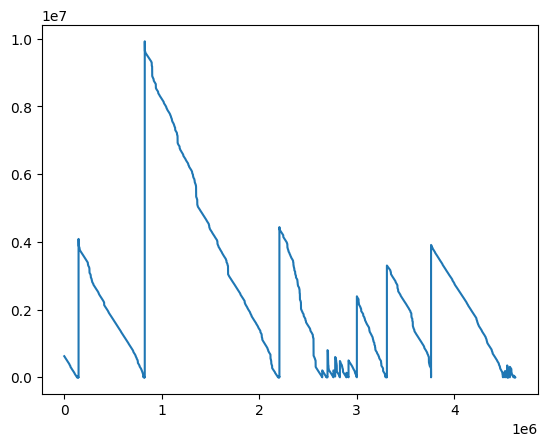

In [308]:
plt.plot(range(len(aa)), aa)

In [294]:
df_train_dup.iloc[130943:143980]

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
130943,3907072,01M02,1,9361,10548007,67,43,-0.022398,1.189382,0.785026,...,-0.048540,0.358499,0.022131,-0.013207,-0.122455,1.0,2.787077,3.309812,3.631609,0.803526
130944,3907076,01M02,1,9361,10548007,67,43,-0.019429,1.188926,0.782897,...,-0.068307,0.350789,0.022131,-0.013207,-0.122455,1.0,2.787080,3.309815,3.631613,0.803526
130945,3907080,01M02,1,9361,10548007,67,43,-0.019429,1.188072,0.783535,...,-0.068307,0.350789,0.022131,-0.013207,-0.122455,1.0,2.787084,3.309819,3.631617,0.803526
130946,3907084,01M02,1,9361,10548007,67,43,-0.019429,1.187048,0.784953,...,-0.050292,0.355169,0.022131,-0.013207,-0.122455,1.0,2.787087,3.309823,3.631621,0.803526
130947,3907088,01M02,1,9361,10548007,67,43,-0.019429,1.187787,0.781764,...,-0.050292,0.355169,0.022131,-0.013207,-0.122455,1.0,2.787090,3.309827,3.631625,0.803526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143975,3962372,01M02,1,9194,10551521,67,49,0.011108,1.187958,0.787012,...,-0.053538,0.363231,0.022131,-0.013207,-0.122455,1.0,2.802172,3.326736,3.649204,0.803526
143976,3962376,01M02,1,9194,10551521,67,49,0.011108,1.188186,0.784599,...,-0.053538,0.363231,0.022131,-0.013207,-0.122455,1.0,2.802175,3.326740,3.649208,0.803526
143977,3962380,01M02,1,9194,10551521,67,49,0.011108,1.187901,0.785310,...,-0.055042,0.352016,0.022131,-0.013207,-0.122455,1.0,2.802179,3.326742,3.649210,0.803526
143978,3962384,01M02,1,9194,10551521,67,49,0.011108,1.188129,0.783466,...,-0.055042,0.352016,0.022131,-0.013207,-0.122455,1.0,2.802182,3.326745,3.649214,0.803526


In [293]:
df_train_dup[df_train_dup['time'] == 3962388].index

Index([143979], dtype='int64')

In [63]:
from sklearn.preprocessing import MinMaxScaler

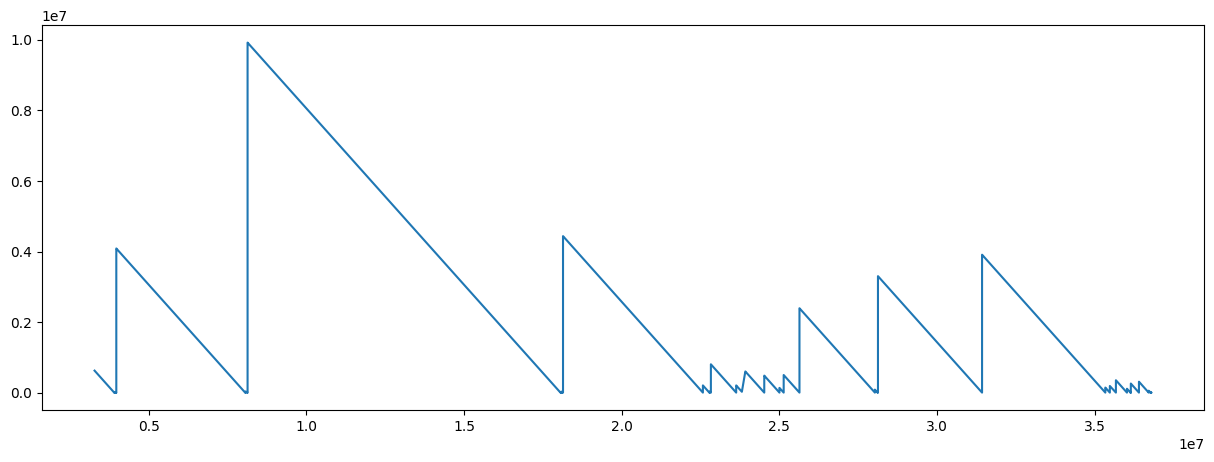

In [61]:
plt.figure(figsize=(15,5))
plt.plot(df_ttf['time'], df_ttf['TTF_FlowCool Pressure Dropped Below Limit'])
plt.ylim(0,700000)
plt.xlim(3283834,3962392)

In [288]:
df_ttf[df_ttf['TTF_FlowCool Pressure Dropped Below Limit'] == 0]

,time,TTF_FlowCool Pressure Dropped Below Limit,TTF_Flowcool Pressure Too High Check Flowcool Pump,TTF_Flowcool leak
131033,3907068,0.0,8523236.0,9280.0
144072,3962388,0.0,8467916.0,8512.0
146084,3971424,0.0,8458880.0,4153010.0
146565,3973348,0.0,8456956.0,4151086.0
816430,8072052,0.0,4358252.0,52382.0
822332,8123030,0.0,4307274.0,1404.0
822821,8124986,0.0,4305318.0,1148114.0
822933,8125434,0.0,4304870.0,1147666.0
823355,8127122,0.0,4303182.0,1145978.0
2203555,18108796,0.0,3796544.0,33638.0
